# Automated Logo Generation Sample
## Overview
Designing a compelling and effective company/brand logo is crucial yet time-consuming and expensive. This usecase explores an AI-driven approach to streamlines logo generation by combining the capabitlities of small language models and diffusion models

## How it works?
<img width=800 alt="image" src="./assets/logo_generation.png"/>

## Login to Huggingface Hub to access the Models
1. Get access to gated models i.e. Stable diffusion and Llama 3.2.
2. Fetch access token from your huggingface account
3. Paste the access token when prompted below

In [1]:
from huggingface_hub import login
login()

## Import Necessary Packages

In [33]:
# imports required for the sample
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from diffusers import DiffusionPipeline, StableDiffusion3Pipeline
import ipywidgets as widgets
from IPython.display import display
# to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [34]:
# Create a local directory to save generated logos
from pathlib import Path
import os
ROOT_DIR = Path.cwd()
LOGO_DIR = ROOT_DIR / 'logos'
LOGO_DIR.mkdir(parents=True, exist_ok=True)

## Save logo into a local directory

In [25]:
def save_image(image, model, company_name):
    """
    Saves a generated logo image into a local directory
    Args:
        image(PIL Image format): Generated Company Logo,
        model(str): User Selected Model,
        company_name(str): User provided company name(along with other details)
    Returns:
        PIL Image: Saved to local directory
    """
    try:
        if model == "stabilityai/stable-diffusion-3-medium-diffusers":
            model_name = "sd3m"
        else:
            model_name = "sd3.5m"
        return image.save(f"./logos/{company_name}_{model_name}.png")
    except Exception as e:
        print("Failed to save the model to local directory")
        raise e

## Diffusion Prompt Generation using SLM

With the help of few-shot prompt strategy, small language model(SLM) converts a structured company information into a detailed image diffusion prompt which further guides the diffusion model.

In [3]:
def generate_diffusion_prompt(prompt):
    """
    Generates a image diffusion prompt using loaded Llama 3.2 1B Model
    Args:
        prompt(str): The formatted prompt to send to Llama Model
    Returns:
        str: Generated precise image diffusion prompt
    """
    try:
        tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
        model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B")
        device = "xpu" if torch.xpu.is_available() else "cpu"
        model = model.to(device)    
        inputs = tokenizer(prompt, return_tensors="pt")
        inputs = inputs.to(device)
        torch.xpu.empty_cache()
        outputs = model.generate(
            **inputs,
            max_length=512,  
            temperature=0.7,
            do_sample=True,
            top_p=1.0,
        )
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        text = generated_text.find("Output Prompt:\n")
        diffusion_prompt = generated_text[text + len("Output Prompt:\n"):].strip()
        del model, tokenizer, inputs, outputs
        return diffusion_prompt
    except Exception as e:
            print("Failed to generate diffusion prompt")
            raise e

### Few-shot prompt to the Small Language Model(SLM)

In [4]:
def make_prompt(name, info, style, color, ctype):
    """
    Gathers user provided textual company details and formats them into a few-shot prompt for an SLM Model
    Args:
        name(str): User Provided Company Name
        info(str): User Provided Company Information
        style(str): User chosen logo style
        color(str): User chosen logo color palette
        ctype(str): User chosen company type(eg. e-commerce, restaurant, etc)
    Returns: 
        prompt(str): Formatted prompt with few-shot prompt strategy
    """
    try:
        prompt = f"""
        You are a helpful assistant that can generate creative prompts for image diffusion models. 
        Your goal is to create a prompt that are specific and tailored to the given company information. 
        I will provide you with examples of company details and corresponding image diffusion prompts.
    
        Here are a few examples to get us started:
        
        Example 1:
        Company Name: TechForward Solutions
        Company Info: A software company specializing in AI solutions for businesses.
        Company Type: Technology: Software, hardware
        Logo Style: Modern, Geometric
        Logo Color Palette: Electric blue, silver, white
        Prompt: A modern, geometric logo for TechForward Solutions, featuring a stylized, interconnected network of glowing lines, in electric blue, silver, and white. Display 'TechForward Solutions'.
    
        Example 2:
        Company Name: Sweet Harmony Bakery
        Company Info: A local bakery offering a variety of pastries, cakes, and breads.
        Company Type: Food
        Logo Style: Vintage, Hand-drawn
        Logo Color Palette: Warm beige, pastel pink, light yellow
        Prompt: A vintage, hand-drawn logo for Sweet Harmony Bakery, featuring a delicate illustration of a pastry, cake, and bread, in warm beige, pastel pink, and light yellow. Display 'Sweet Harmony Bakery'
        
        Example 3:
        Company Name: OceanVista Resorts
        Company Info: A luxury resort chain with locations in tropical coastal areas.
        Company Type: Travel
        Logo Style: Elegant, Minimalist
        Logo Color Palette: Turquoise, sand, white
        Prompt: An elegant, minimalist logo for OceanVista Resorts, featuring a stylized depiction of a wave and a setting sun, in turquoise, sand, and white. Display 'OceanVista Resorts'.
        
        Now, Generate only diffusion output prompt for the below company information:
    
        Company Name: {name}
        Company Info: {info}
        Company Type: {ctype}
        Logo Style: {style}
        Logo Color Palette: {color}
        Output Prompt:
        """
        return prompt
    except Exception as e:
            print("Failed to format the prompt. Enter complete company details\n")
            raise e

## User Input: Company/Brand Information

Below are the user provided details to generate a logo for company/brand.

**Sample Inputs**:
1. Aroma Brews
    - company_name = 'Aroma Brews'
    - company_info = 'Cafe'
    - company_type = 'Food Business: Restaurant, cafe'
    - logo_style = 'Illustrative: Detailed, artistic'
    - logo_color_palette = 'Earthy: Natural tones'
2. Pet Paradise
    - company_name = 'Pet Paradise'
    - company_info = 'Retailer of pet food and accessories'
    - company_type = 'Retail: Shops, stores'
    - logo_style = 'Organic: Natural, flowing'
    - logo_color_palette = 'Vibrant: Bright, colorful'


In [5]:
company_name = "Mega Mart"
company_info = "Supermarket"
company_type = "Retail: Shops, stores" # 'E-commerce: Online store', 'Food Business: Restaurant, cafe'
logo_style = "Minimalist: Simple, uncluttered" # 'Illustrative: Detailed, artistic', Geometric: Shapes, patterns',
logo_color_palette = "Warm: Reds, oranges, yellows" # 'Cool: Pastel Blues, greens, purples', Neutral: Grays, browns, beiges'

prompt = make_prompt(company_name, company_info, logo_style, logo_color_palette, company_type)
final_prompt = generate_diffusion_prompt(prompt)
print(f"Generated Prompt: {final_prompt}")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generated Prompt: A minimalist, uncluttered logo for Mega Mart, featuring a stylized depiction of a shopping basket, in warm reds, oranges, and yellows. Display 'Mega Mart'


In [8]:
options = [
        "stabilityai/stable-diffusion-3-medium-diffusers",
        "stabilityai/stable-diffusion-3.5-medium",
        # "stabilityai/stable-diffusion-3.5-large",
]
model = widgets.Dropdown(
    options=options,
    value='stabilityai/stable-diffusion-3-medium-diffusers',
    description='Diffusion Model:',
    disabled=False,
)

In [9]:
display(model)

Dropdown(description='Diffusion Model:', options=('stabilityai/stable-diffusion-3-medium-diffusers', 'stabilit…

## Logo Generation using Diffusion Models

In [10]:
def logo_generator(model):
    """
    Generates a company logo based on the SLM tuned diffusion prompt
    Args:
        model(str): User selected Model from the dropdown
    Returns:
        image(PIL Image): Generated Company Logo
    """
    
    pipe = StableDiffusion3Pipeline.from_pretrained(
        model,
        text_encoder_3=None,
        tokenizer_3=None,
        torch_dtype=torch.bfloat16)
    pipe = pipe.to("xpu")
    torch.xpu.empty_cache()
    image = pipe(
        prompt=final_prompt,
        negative_prompt="blurry, incorrect spelling, wrong names",
        num_inference_steps=30,
        height=512,
        width=512,
        guidance_scale=8.5,
    ).images[0]
    del pipe
    return image

<div class="alert alert-block alert-warning"> Image generation might take 1-3 minutes. Please be patient! </div>

In [23]:
image = logo_generator(model.value)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

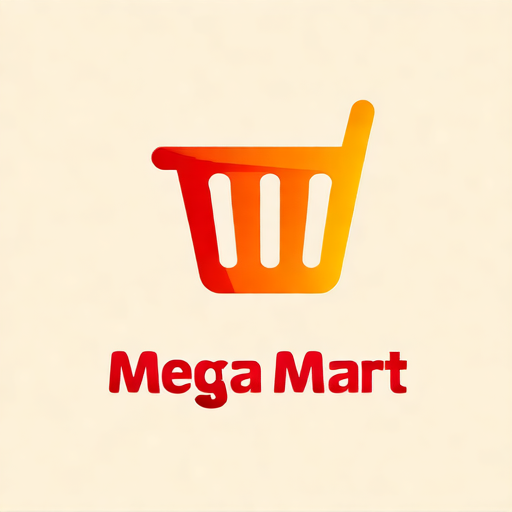

In [24]:
image

In [27]:
save_image(image, model.value, company_name)